In [1]:
from function_for_prediction import *
import numpy as np
import pandas as pd
from sklearn.preprocessing import Imputer,StandardScaler
from scipy.stats.stats import pearsonr
from sklearn.feature_selection import SelectKBest,SelectPercentile,RFE,RFECV,SelectFromModel
from sklearn.svm import SVR,SVC
from sklearn.linear_model import Lasso
from sklearn.svm import LinearSVR
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import seaborn as sns
import re
import matplotlib.pyplot as plt
import matplotlib
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline


/Users/weiyansun/anaconda/envs/python2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/weiyansun/anaconda/envs/python2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def fill_non_num_mode(df,obj_col):
    for col in obj_col:
        mode=df[col].value_counts().index[0]
        df[col]=df[col].fillna(mode)
    return df

# return only n-1 col
def get_dummy_and_append(numeric_df,non_numeric_df):
    for col in non_numeric_df.columns:
        dummy_df=pd.get_dummies(non_numeric_df[col]).ix[:,0:-1]
        numeric_df=pd.concat([numeric_df, dummy_df], axis=1)
    return numeric_df

def split_data(x_data,y_data,size=0.1):
    return train_test_split(x_data,y_data,test_size=size)

# score_type accpet R^2, abs error
def train_eval_model(model,x_train,y_train,x_test,y_test,score_type="R^2"):
    model.fit(X=x_train,y=y_train)
    predicted_y_train = model.predict(x_train)
    predicted_y_test = model.predict(x_test)
    if score_type=="R^2":
        return [r2_score(y_train,predicted_y_train),r2_score(y_test,predicted_y_test)]
    elif score_type=='abs_error':
        return [mean_absolute_error(y_train,predicted_y_train),mean_absolute_error(y_test,predicted_y_test)]
    
def cov_analysis(final_data,target):
    low_covariance_1 = []
    low_covariance_2 = []
    low_covariance_15 = []
    low_covariance_2g = []
    for x in final_data.columns:
        z = (np.corrcoef(final_data[x],y=target))
        if(np.fabs(z[0,1]) < 0.1):
            low_covariance_1.append(x)
        elif(np.fabs(z[0,1]) < 0.15):
            low_covariance_15.append(x)
        elif(np.fabs(z[0,1])<0.2):
            low_covariance_2.append(x)
        else:
            low_covariance_2g.append(x)
    return [low_covariance_1,low_covariance_15,low_covariance_2,low_covariance_2g]

In [3]:
data=pd.read_csv("movie_metadata_new.csv")
data.columns

Index([u'color', u'director_name', u'num_critic_for_reviews', u'duration',
       u'director_facebook_likes', u'actor_3_facebook_likes', u'actor_2_name',
       u'actor_1_facebook_likes', u'gross', u'genres', u'actor_1_name',
       u'movie_title', u'num_voted_users', u'cast_total_facebook_likes',
       u'actor_3_name', u'facenumber_in_poster', u'plot_keywords',
       u'movie_imdb_link', u'num_user_for_reviews', u'language', u'country',
       u'content_rating', u'budget', u'title_year', u'actor_2_facebook_likes',
       u'imdb_score', u'aspect_ratio', u'movie_facebook_likes'],
      dtype='object')

In [4]:
data.dropna(subset=["gross"],inplace=True)

In [5]:
## model for gross

# data preprocessing, select some str variable and fill na with mode
obj_col=['language','country','content_rating']
data=fill_non_num_mode(data,obj_col)

# select only numeric variable

numeric_data=data.select_dtypes(exclude=['object'])

# make our goal: imdb score a single vector
score=numeric_data['gross']
numeric_data=numeric_data.drop(['gross'],axis=1)


# fillna with mean and normalize the feature.after this combine with dummy variable.
imp = Imputer(missing_values="NaN",strategy="mean",axis=0)      #default values
numeric_data[numeric_data.columns]=imp.fit_transform(numeric_data)
scaler = StandardScaler()
numeric_data[numeric_data.columns] = scaler.fit_transform(numeric_data[numeric_data.columns])

# add dummies to numeric_data and get our final data
final_data=get_dummy_and_append(numeric_data,data[obj_col])

In [6]:
cov=cov_analysis(final_data,score)
print cov[-1], "\n", cov[-2], "\n", cov[1], "\n", cov[0]

['num_critic_for_reviews', 'duration', 'actor_3_facebook_likes', 'actor_1_facebook_likes', 'num_voted_users', 'cast_total_facebook_likes', 'num_user_for_reviews', 'actor_2_facebook_likes', 'movie_facebook_likes', 'R'] 
['director_facebook_likes', 'imdb_score', 'English', 'USA', 'PG-13'] 
['budget', 'PG'] 
['facenumber_in_poster', 'title_year', 'aspect_ratio', 'Aboriginal', 'Arabic', 'Aramaic', 'Bosnian', 'Cantonese', 'Chinese', 'Czech', 'Danish', 'Dari', 'Dutch', 'Dzongkha', 'Filipino', 'French', 'German', 'Greek', 'Hebrew', 'Hindi', 'Hungarian', 'Icelandic', 'Indonesian', 'Italian', 'Japanese', 'Kazakh', 'Korean', 'Mandarin', 'Maya', 'Mongolian', 'None', 'Norwegian', 'Persian', 'Polish', 'Portuguese', 'Romanian', 'Russian', 'Spanish', 'Swedish', 'Telugu', 'Thai', 'Vietnamese', 'Afghanistan', 'Argentina', 'Aruba', 'Australia', 'Belgium', 'Brazil', 'Cameroon', 'Canada', 'Chile', 'China', 'Colombia', 'Czech Republic', 'Denmark', 'Finland', 'France', 'Georgia', 'Germany', 'Greece', 'Hong 

In [7]:
# select final col by cov_analysis
final_col=['num_critic_for_reviews', 'duration', 'actor_3_facebook_likes', 'actor_1_facebook_likes', 'num_voted_users', 'cast_total_facebook_likes', 'num_user_for_reviews', 'actor_2_facebook_likes', 'movie_facebook_likes', 'R','director_facebook_likes', 'imdb_score', 'English', 'USA', 'PG-13','budget', 'PG'] 
final_data=final_data[final_col]

In [11]:
# svr with diff kernel
svr_linear_model = LinearSVR()
svr_model = SVR(kernel='rbf') #default
svr_poly_model = SVR(kernel="poly") #default degree is 3

# knn with diff n, uniform
default_knn = KNeighborsRegressor(n_neighbors=5)#,weights='distance')
knn_10 = KNeighborsRegressor(n_neighbors=10,weights='distance')
knn_20 = KNeighborsRegressor(n_neighbors=20)#,weights='distance')
# knn with diff n, distance
#distance

lr=LinearRegression()
rf=RandomForestRegressor()
rg=Ridge()
adaboost=AdaBoostRegressor()

In [9]:
training_x,test_x,training_Y,test_y = split_data(final_data,score)

In [33]:
np.log?

In [34]:
rf=RandomForestRegressor(n_estimators=10, criterion='mae',max_features=None)
train_eval_model(rf,training_x,np.log(training_Y),test_x,np.log(test_y),score_type="abs_error")[1]
    

1.0174773134581847

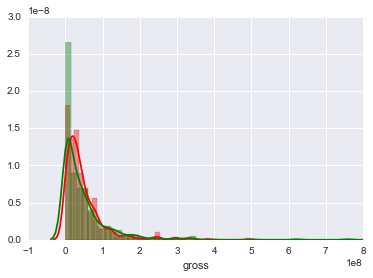

In [31]:
np.exp(rf.predict(test_x))

sns.distplot(,hist=True,color="red")
sns.distplot(test_y,hist=True,color="green")

In [40]:
(abs(test_y-np.exp(rf.predict(test_x)))/test_y)

2185.3993173330186

In [36]:
sum(abs(test_y-np.exp(rf.predict(test_x)))/test_y)/len(test_y)

13.944182912847044

In [17]:
test_y.mean()-21752422.31536058

26483547.32887019

In [13]:
model_list=[svr_linear_model,svr_model,svr_poly_model,knn_10,lr,rf,rg,adaboost]
for model in model_list:
    temp=train_eval_model(model,training_x,training_Y,test_x,test_y,score_type="abs_error")
    model_name=re.search('(.*)\(',str(model)).group(1)
    #print(str(model_name)," training error", str(temp[0]))
    print(str(model_name)," testing error", str(temp[1]))

('LinearSVR', ' testing error', '48225696.5518')
('SVR', ' testing error', '40695646.241')
('SVR', ' testing error', '40695219.7404')
('KNeighborsRegressor', ' testing error', '25258910.9717')
('LinearRegression', ' testing error', '30219066.2287')
('RandomForestRegressor', ' testing error', '22646513.5579')
('Ridge', ' testing error', '30214737.1731')
('AdaBoostRegressor', ' testing error', '56452029.4349')


In [ ]:
index=list(test_x.index)
predict_df=data.loc[index,["movie_title","imdb_score",'gross']]
predict_df['predict']=predicted_y_test


In [ ]:
predict_y_test_knn=knn_10.predict(test_x)
predicted_y_test_rf=rf.predict(test_x)
predicted_y_test_rg=rg.predict(test_x)
predicted_y_test=predicted_y_test_rf*0.8+predict_y_test_knn*0.2
sum(abs(predicted_y_test-test_y))/len(predicted_y_test)